References:

https://www.geeksforgeeks.org/sql/window-functions-in-sql/

https://medium.com/@manutej/mastering-sql-window-functions-guide-e6dc17eb1995

https://medium.com/@pulumatirambabu/window-functions-8eafe1ceb218

https://builtin.com/data-science/advanced-sql

https://airbyte.com/data-engineering-resources/advanced-sql-concepts

https://medium.com/@techsuneel99/20-advanced-sql-techniques-with-practical-examples-b47490d9896d

https://www.dataforgelabs.com/advanced-sql-concepts

https://www.stratascratch.com/blog/advanced-sql-concepts-to-improve-your-and-code-s-performance/

https://www.reddit.com/r/ProgrammerHumor/comments/wuu689/the_sql_iceberg/#lightbox

https://www.linkedin.com/posts/preethysai07_sql-dataengineering-dataanalysis-activity-7365238942184439808-RZKS

In [4]:
!pip install duckdb --quiet

In [5]:
import duckdb
import pandas as pd
import numpy as np

In [6]:
df = pd.DataFrame({
    "region": ["North", "North", "North", "South", "South", "South"],
    "salesperson": ["Alice", "Bob", "Alice", "Bob", "Alice", "Bob"],
    "month": ["Jan", "Jan", "Feb", "Feb", "Mar", "Mar"],
    "amount": [100, 120, 130, 90, 160, 140],
})
duckdb.register("sales_df", df)
df

,region,salesperson,month,amount
0,North,Alice,Jan,100
1,North,Bob,Jan,120
2,North,Alice,Feb,130
3,South,Bob,Feb,90
4,South,Alice,Mar,160
5,South,Bob,Mar,140


# Window Functions Definition

A window function is basically a way to add calculations to rows that would otherwise require a GROUP BY statement.

Window functions use PARTITION BY statement instead, created groups are called window.

Since GROUP BY collapses rows in the result, window functions return all rows with grouped statistics.

The calculation is done across related rows, and for certain window functions, PARTITION BY can be omitted.

ORDER BY statement is used to order values inside window, for certain window function order is meaningless.

**Use cases for window functions:**

https://medium.com/@manutej/mastering-sql-window-functions-guide-e6dc17eb1995


1. *You Want to Compare Blocks Without Mixing Them Up*

Imagine you want to see if one block is taller than the blocks right next to it. A Window Function lets you look at each block and its neighbors without mixing them all up, so you can easily compare them.

2. *You Want to Count or Add Up Blocks in a Row*

If you want to count how many blocks TOTAL you have in a column or add up their numbers, a Window Function can do that for you, looking at each block one by one and keeping a running total. It can help you find a running average of those blocks as well!

3. *You Want to Find the Biggest or Smallest Block in a Section*

Let’s say you have your blocks sorted in rows by color, and you want to find the biggest block in each row. A Window Function helps you look at each row separately and pick out the biggest block in each one.

4. *You Want to Give Blocks a Score or a Rank*

If you want to give each block a score or a rank based on its size or color, a Window Function can do that too. It looks at all the blocks, sorts them how you want, and then gives each one a number to show its rank in the overall set of blocks.

5. *You Want to See How Blocks Compare to Their Friends*

Maybe you want to see if a block is taller than the average height of the blocks around it. A Window Function can look at a block and its buddies, calculate the average height, and then tell you how that block compares.



https://www.geeksforgeeks.org/sql/window-functions-in-sql/


General Syntax:

```
SELECT column_name1,
       window_function(column_name2)
       OVER ([PARTITION BY column_name3] [ORDER BY column_name4]) AS new_column
FROM table_name;
```

OVER statement is definition of grouping, that window functions, define before it calls.

A single SELECT can have multiple multiple window_function and OVER pairs,

so in single select you can call statistics over unrelated groups.

Terminology:

- window_function: Any aggregate or ranking function (SUM(), AVG(), ROW_NUMBER(), etc.)
- column_name1: Regular column(s) to be selected in the output
- column_name2: Column on which the window function is applied
- column_name3: Column used for dividing rows into groups (PARTITION BY)and
 - column_name4: Column used to define order of rows within each partition (ORDER BY)
- new_column: Alias for calculated result of the window function
- table_name: table from which data is selected


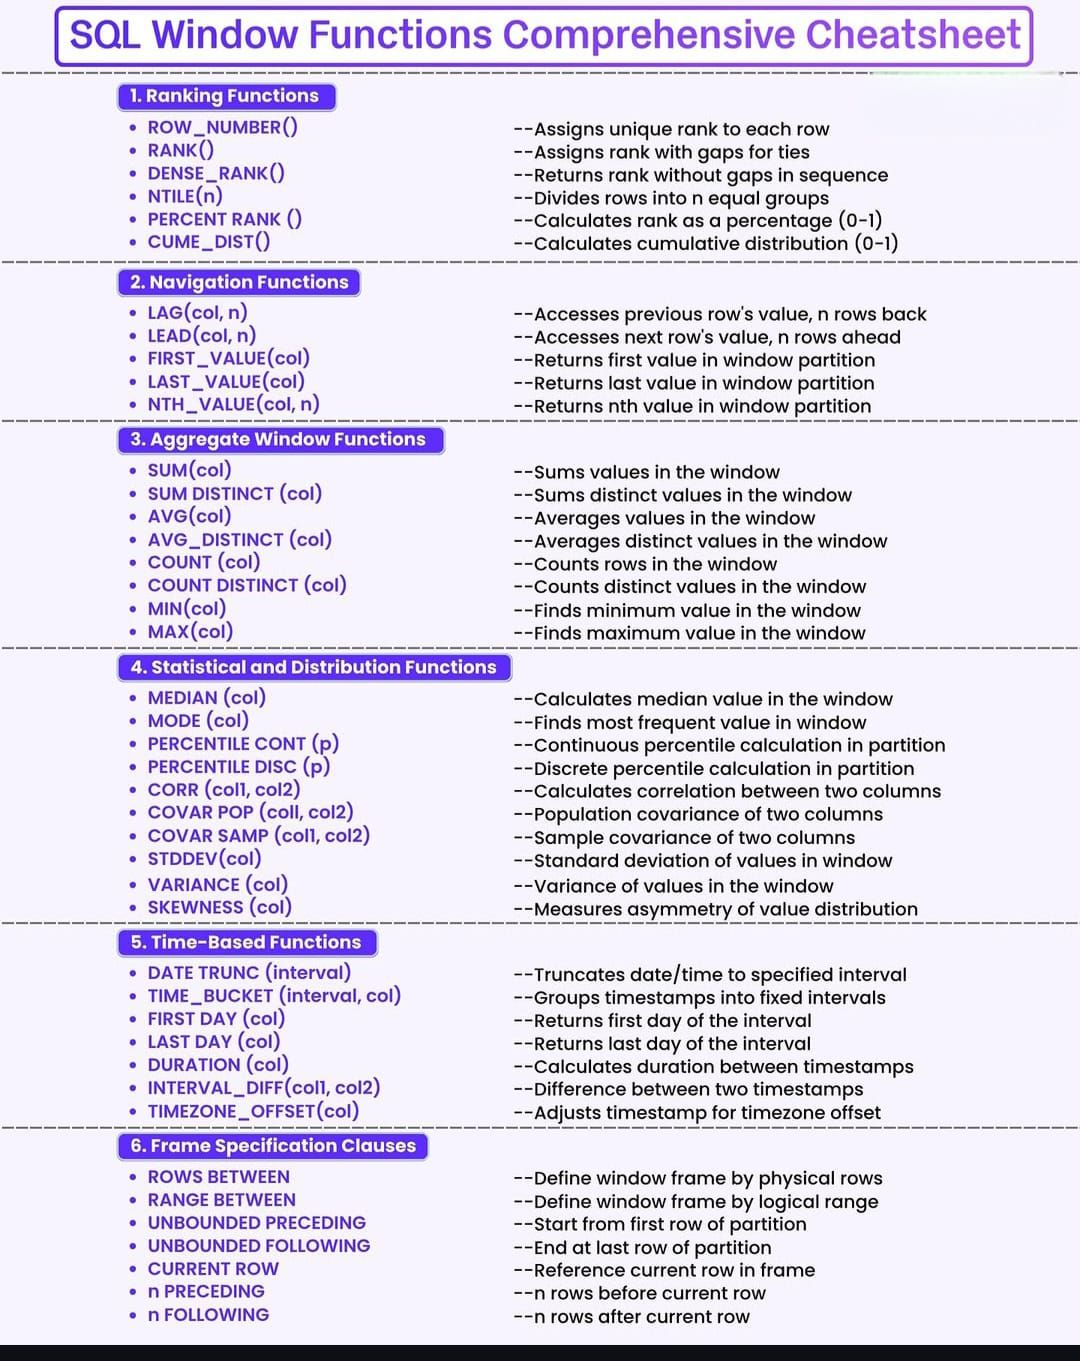

# AGGREGATE WINDOW FUNCTIONS

*Summarize rows*

These do some kind of aggregate calculations over a window of rows while keeping each row visible.

These functions have equivalents that can produce same results,
but since they use GROUP BY, they collapse rows into single row.

ORDER BY here is optional:

Because aggregates can work either as:
- static aggregates (no ordering)
- running/moving aggregates (with ordering)


One important observation:


Aggregate window functions when no ORDER BY is used,
will always return the same value for every row in a partition.



For other two categories, these things are valid for aggregate window functions, are not true:

1. Same results for every row in partition happen only by coincidence or specific scenarions.
2. ORDER BY STATEMENT is always mandatory.
3. There are no SQL constructs, that could achieve the same results directly, at best very hacky workarounds.

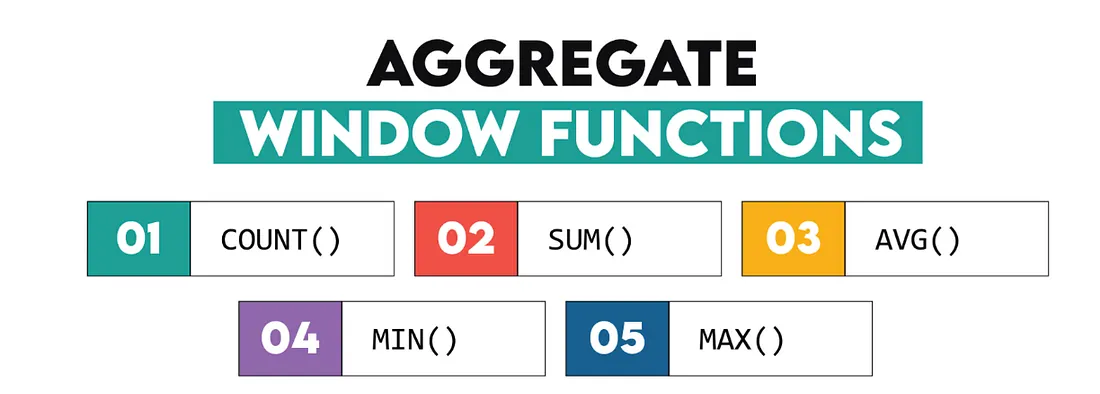

In [7]:
df = pd.DataFrame({
    "category": ["A", "A", "A", "B", "B", "C"],
    "date": [
        "2024-01-01", "2024-01-02", "2024-01-03",
        "2024-01-01", "2024-01-02", "2024-01-05",
    ],
    "amount": [10, 20, 15, 5, 12, 30],
})
df

,category,date,amount
0,A,2024-01-01,10
1,A,2024-01-02,20
2,A,2024-01-03,15
3,B,2024-01-01,5
4,B,2024-01-02,12
5,C,2024-01-05,30


In [8]:
duckdb.sql("CREATE OR REPLACE TABLE sales AS SELECT * FROM df")

*COUNT*

In [9]:
duckdb.sql("""
SELECT
    category,
    amount,
    COUNT(*) OVER (PARTITION BY category) AS category_count
FROM sales
""")

┌──────────┬────────┬────────────────┐
│ category │ amount │ category_count │
│ varchar  │ int64  │     int64      │
├──────────┼────────┼────────────────┤
│ A        │     10 │              3 │
│ A        │     20 │              3 │
│ A        │     15 │              3 │
│ B        │      5 │              2 │
│ B        │     12 │              2 │
│ C        │     30 │              1 │
└──────────┴────────┴────────────────┘

*SUM*

has two variants, based on fact if ORDER by is used:

1. per partition(NO ORDER BY)

In [10]:
duckdb.sql("""
SELECT
    category,
    date,
    amount,
    SUM(amount) OVER (PARTITION BY category) AS category_total
FROM sales
""")

┌──────────┬────────────┬────────┬────────────────┐
│ category │    date    │ amount │ category_total │
│ varchar  │  varchar   │ int64  │     int128     │
├──────────┼────────────┼────────┼────────────────┤
│ B        │ 2024-01-01 │      5 │             17 │
│ B        │ 2024-01-02 │     12 │             17 │
│ A        │ 2024-01-01 │     10 │             45 │
│ A        │ 2024-01-02 │     20 │             45 │
│ A        │ 2024-01-03 │     15 │             45 │
│ C        │ 2024-01-05 │     30 │             30 │
└──────────┴────────────┴────────┴────────────────┘

2. running average (WITH ORDER BY)

  inside partition, each value will increase total, based on order.

In [11]:
duckdb.sql("""
SELECT
    category,
    date,
    amount,
    SUM(amount) OVER (
        PARTITION BY category
        ORDER BY date
    ) AS running_total
FROM sales
""")

┌──────────┬────────────┬────────┬───────────────┐
│ category │    date    │ amount │ running_total │
│ varchar  │  varchar   │ int64  │    int128     │
├──────────┼────────────┼────────┼───────────────┤
│ A        │ 2024-01-01 │     10 │            10 │
│ A        │ 2024-01-02 │     20 │            30 │
│ A        │ 2024-01-03 │     15 │            45 │
│ B        │ 2024-01-01 │      5 │             5 │
│ B        │ 2024-01-02 │     12 │            17 │
│ C        │ 2024-01-05 │     30 │            30 │
└──────────┴────────────┴────────┴───────────────┘

Running average happends here, because of default value used for FRAME.

In [12]:
duckdb.sql("""
SELECT
    category,
    amount,
    MIN(amount) OVER (PARTITION BY category) AS category_min
FROM sales
""")

┌──────────┬────────┬──────────────┐
│ category │ amount │ category_min │
│ varchar  │ int64  │    int64     │
├──────────┼────────┼──────────────┤
│ A        │     10 │           10 │
│ A        │     20 │           10 │
│ A        │     15 │           10 │
│ B        │      5 │            5 │
│ B        │     12 │            5 │
│ C        │     30 │           30 │
└──────────┴────────┴──────────────┘

*AVG*

In [13]:
duckdb.sql("""
SELECT
    category,
    amount,
    AVG(amount) OVER (PARTITION BY category) AS category_avg
FROM sales
""")

┌──────────┬────────┬──────────────┐
│ category │ amount │ category_avg │
│ varchar  │ int64  │    double    │
├──────────┼────────┼──────────────┤
│ B        │      5 │          8.5 │
│ B        │     12 │          8.5 │
│ A        │     10 │         15.0 │
│ A        │     20 │         15.0 │
│ A        │     15 │         15.0 │
│ C        │     30 │         30.0 │
└──────────┴────────┴──────────────┘

*MIN*

In [14]:
duckdb.sql("""
SELECT
    category,
    amount,
    MIN(amount) OVER (PARTITION BY category) AS category_min
FROM sales
""")

┌──────────┬────────┬──────────────┐
│ category │ amount │ category_min │
│ varchar  │ int64  │    int64     │
├──────────┼────────┼──────────────┤
│ B        │      5 │            5 │
│ B        │     12 │            5 │
│ A        │     10 │           10 │
│ A        │     20 │           10 │
│ A        │     15 │           10 │
│ C        │     30 │           30 │
└──────────┴────────┴──────────────┘

*MAX*

In [15]:
duckdb.sql("""
SELECT
    category,
    amount,
    MAX(amount) OVER (PARTITION BY category) AS category_max
FROM sales
""")

┌──────────┬────────┬──────────────┐
│ category │ amount │ category_max │
│ varchar  │ int64  │    int64     │
├──────────┼────────┼──────────────┤
│ B        │      5 │           12 │
│ B        │     12 │           12 │
│ A        │     10 │           20 │
│ A        │     20 │           20 │
│ A        │     15 │           20 │
│ C        │     30 │           30 │
└──────────┴────────┴──────────────┘

# RANKING WINDOW FUNCTIONS

*Assing rank number*

These assign a rank or position to each row within a partition.

For these functions to work properly, ORDER BY statement must be present.


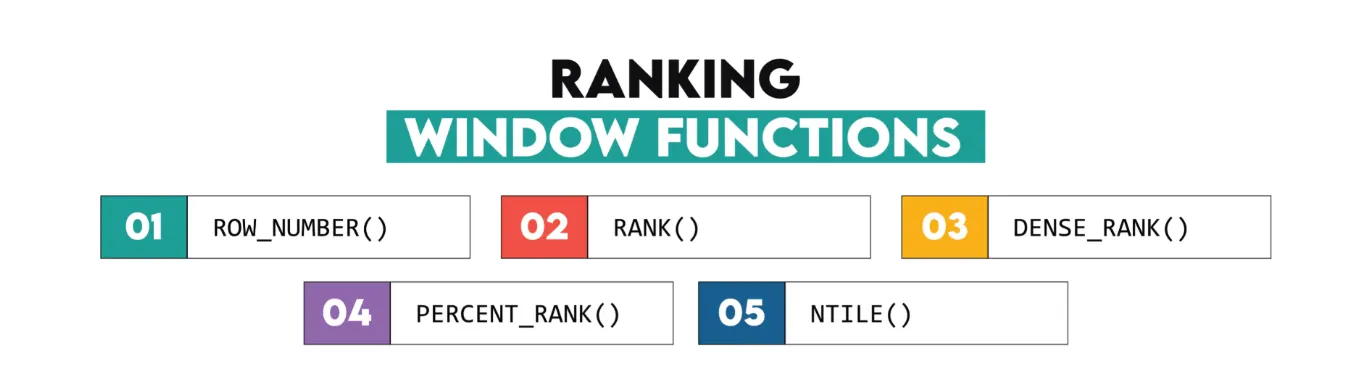

Ranking function always produces values in certain ranges:

N, is number of examples here

ROW_NUMBER always in 1 -> N

RANK always from 1 -> max possible N

DENSE_RANK always from 1 -> max possible N

PERCENT_RANK always in range  0 -> 1

NTILE(n) is always in range 1 -> n

n here is the parameter used.

In [16]:
df = pd.DataFrame({
    "id":      [1, 2, 3, 4, 5, 6],
    "category":["A","A","A","B","B","B"],
    "amount":  [10, 10, 20, 5, 12, 12]
})
df

,id,category,amount
0,1,A,10
1,2,A,10
2,3,A,20
3,4,B,5
4,5,B,12
5,6,B,12


In [17]:
duckdb.sql("CREATE OR REPLACE TABLE sales AS SELECT * FROM df")

ROW_NUMBER, RANK and DENSE_RANK do the same thing, but differ in tie handling.

All three functions:
- look at a partition
- sort the rows
- assign a rank-like number

The only difference is how they treat ties

*ROW_NUMBER*




*Strict sequence*

Assigns a unique sequential number per partition.

Even if ties happen because of ordering, different number will always be assigned

In [18]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    ROW_NUMBER() OVER (
        PARTITION BY category
        ORDER BY amount
    ) AS ranking_in_category_by_amount
FROM sales
ORDER BY category, amount, id
""")


┌───────┬──────────┬────────┬───────────────────────────────┐
│  id   │ category │ amount │ ranking_in_category_by_amount │
│ int64 │ varchar  │ int64  │             int64             │
├───────┼──────────┼────────┼───────────────────────────────┤
│     1 │ A        │     10 │                             1 │
│     2 │ A        │     10 │                             2 │
│     3 │ A        │     20 │                             3 │
│     4 │ B        │      5 │                             1 │
│     5 │ B        │     12 │                             2 │
│     6 │ B        │     12 │                             3 │
└───────┴──────────┴────────┴───────────────────────────────┘

*RANK*




*Competition ranking*

Tied rows share the same rank, but after that gap will be in place, for the number of tied rows

Here if tie occurs, gap will be visible after it.

More records are present in tie, the larger the gab, or based on formula:

`GAP = NR_OF_RECORDS_IN_TIE - 1`

In [19]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    RANK() OVER (
        PARTITION BY category
        ORDER BY amount
    ) AS rank_val
FROM sales
ORDER BY category, amount, id
""")

┌───────┬──────────┬────────┬──────────┐
│  id   │ category │ amount │ rank_val │
│ int64 │ varchar  │ int64  │  int64   │
├───────┼──────────┼────────┼──────────┤
│     1 │ A        │     10 │        1 │
│     2 │ A        │     10 │        1 │
│     3 │ A        │     20 │        3 │
│     4 │ B        │      5 │        1 │
│     5 │ B        │     12 │        2 │
│     6 │ B        │     12 │        2 │
└───────┴──────────┴────────┴──────────┘

*DENSE_RANK*

*Compact ranking*

After ties no gaps will appear in the sequence.

In [20]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    DENSE_RANK() OVER (
        PARTITION BY category
        ORDER BY amount
    ) AS dense_rank_val
FROM sales
ORDER BY category, amount, id
""")

┌───────┬──────────┬────────┬────────────────┐
│  id   │ category │ amount │ dense_rank_val │
│ int64 │ varchar  │ int64  │     int64      │
├───────┼──────────┼────────┼────────────────┤
│     1 │ A        │     10 │              1 │
│     2 │ A        │     10 │              1 │
│     3 │ A        │     20 │              2 │
│     4 │ B        │      5 │              1 │
│     5 │ B        │     12 │              2 │
│     6 │ B        │     12 │              2 │
└───────┴──────────┴────────┴────────────────┘

*PERCENT_RANK*

Is the same value as RANK(), but expressed in a percentage way.

`PERCENT_RANK = (ROW_RANK - 1) / (number of rows in window partition - 1)`

In [21]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    PERCENT_RANK() OVER (
        PARTITION BY category
        ORDER BY amount
    ) AS percent_rank_val
FROM sales
ORDER BY category, amount, id
""")


┌───────┬──────────┬────────┬──────────────────┐
│  id   │ category │ amount │ percent_rank_val │
│ int64 │ varchar  │ int64  │      double      │
├───────┼──────────┼────────┼──────────────────┤
│     1 │ A        │     10 │              0.0 │
│     2 │ A        │     10 │              0.0 │
│     3 │ A        │     20 │              1.0 │
│     4 │ B        │      5 │              0.0 │
│     5 │ B        │     12 │              0.5 │
│     6 │ B        │     12 │              0.5 │
└───────┴──────────┴────────┴──────────────────┘

*NTILE(n)*


Split your ordered rows into n buckets, of equal size.

- Splits rows into n buckets
- Buckets are numbered 1 to n
- Buckets are as equal in size as possible
- Earlier buckets get extra rows if needed
- Ties do not affect bucket assignment

Because of this rules:

*Ties can end up in different tiles*

example usages of NTILE:



- Quartiles (NTILE(4))
- Deciles (NTILE(10))
- Percentile buckets (NTILE(100))
- Balanced grouping for sampling or A/B testing

In [22]:
df = pd.DataFrame({
    "id":      [1, 2, 3, 4, 5, 6],
    "category":["A","A","A","B","B","B"],
    "amount":  [10, 10, 20, 5, 12, 12],
})
df

,id,category,amount
0,1,A,10
1,2,A,10
2,3,A,20
3,4,B,5
4,5,B,12
5,6,B,12


In [23]:
duckdb.sql("CREATE OR REPLACE TABLE sales AS SELECT * FROM df")

What happens if number of rows N in partition,

is number of rows is not divisible b n,

n is parameter number of tiles.

The difference in size between any two tiles is at most 1.

Earlier tiles in partition get more rows here.

Extra tiles go to first rows.

In [24]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    NTILE(2) OVER (
        PARTITION BY category
        ORDER BY amount
    ) AS ntile_2
FROM sales
ORDER BY category, amount, id
""")

┌───────┬──────────┬────────┬─────────┐
│  id   │ category │ amount │ ntile_2 │
│ int64 │ varchar  │ int64  │  int64  │
├───────┼──────────┼────────┼─────────┤
│     1 │ A        │     10 │       1 │
│     2 │ A        │     10 │       1 │
│     3 │ A        │     20 │       2 │
│     4 │ B        │      5 │       1 │
│     5 │ B        │     12 │       1 │
│     6 │ B        │     12 │       2 │
└───────┴──────────┴────────┴─────────┘

Here each tile gets same number.

In [25]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    NTILE(3) OVER (
        PARTITION BY category
        ORDER BY amount
    ) AS ntile_3
FROM sales
ORDER BY category, amount, id
""")

┌───────┬──────────┬────────┬─────────┐
│  id   │ category │ amount │ ntile_3 │
│ int64 │ varchar  │ int64  │  int64  │
├───────┼──────────┼────────┼─────────┤
│     1 │ A        │     10 │       1 │
│     2 │ A        │     10 │       2 │
│     3 │ A        │     20 │       3 │
│     4 │ B        │      5 │       1 │
│     5 │ B        │     12 │       2 │
│     6 │ B        │     12 │       3 │
└───────┴──────────┴────────┴─────────┘

If there are more tiles, that there are rows in partition.


Last tiles will have no rows, other tiles will have only 1 row.

In [26]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    NTILE(4) OVER (
        PARTITION BY category
        ORDER BY amount
    ) AS ntile_4
FROM sales
ORDER BY category, amount, id
""")

┌───────┬──────────┬────────┬─────────┐
│  id   │ category │ amount │ ntile_4 │
│ int64 │ varchar  │ int64  │  int64  │
├───────┼──────────┼────────┼─────────┤
│     1 │ A        │     10 │       1 │
│     2 │ A        │     10 │       2 │
│     3 │ A        │     20 │       3 │
│     4 │ B        │      5 │       1 │
│     5 │ B        │     12 │       2 │
│     6 │ B        │     12 │       3 │
└───────┴──────────┴────────┴─────────┘

# VALUE WINDOW FUNCTIONS

*Looks at other rows*

These return a value from another row in the window relative to the current row.

They is the only categories, where you reach into other rows in partition.

LAG() and LEAD() are sometimes reffered to as Offset Window Functions.

LAG and LEAD

always produce exactly one NULL per partition, for boundary rows.

First row has NO previous row, while last row has NO next row.

FIRST_VALUE, LAST_VALUE, NTH_VALUE

return the same value for every row when using a full ROWS frame

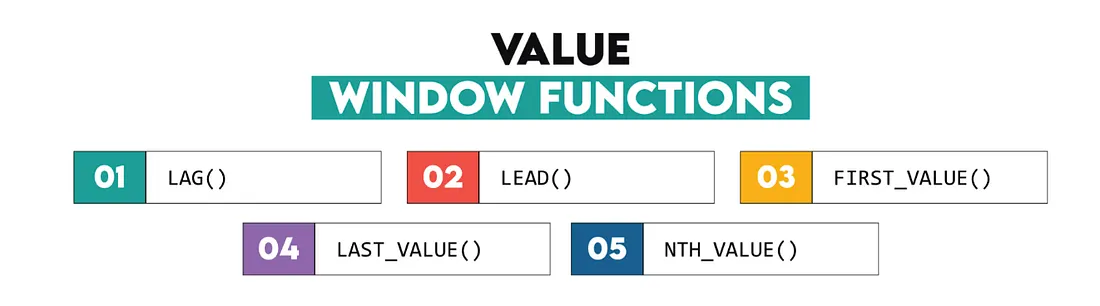

In [27]:
df = pd.DataFrame({
    "id":      [1, 2, 3, 4, 5, 6],
    "category":["A","A","A","B","B","B"],
    "amount":  [10, 15, 20, 5, 12, 18],
})

In [28]:
duckdb.sql("CREATE OR REPLACE TABLE sales AS SELECT * FROM df")

*LAG*

In [29]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    LAG(amount) OVER (
        PARTITION BY category
        ORDER BY amount
    ) AS prev_amount
FROM sales
ORDER BY category, amount
""")

┌───────┬──────────┬────────┬─────────────┐
│  id   │ category │ amount │ prev_amount │
│ int64 │ varchar  │ int64  │    int64    │
├───────┼──────────┼────────┼─────────────┤
│     1 │ A        │     10 │        NULL │
│     2 │ A        │     15 │          10 │
│     3 │ A        │     20 │          15 │
│     4 │ B        │      5 │        NULL │
│     5 │ B        │     12 │           5 │
│     6 │ B        │     18 │          12 │
└───────┴──────────┴────────┴─────────────┘

*LEAD*

In [30]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    LEAD(amount) OVER (
        PARTITION BY category
        ORDER BY amount
    ) AS next_amount
FROM sales
ORDER BY category, amount
""")

┌───────┬──────────┬────────┬─────────────┐
│  id   │ category │ amount │ next_amount │
│ int64 │ varchar  │ int64  │    int64    │
├───────┼──────────┼────────┼─────────────┤
│     1 │ A        │     10 │          15 │
│     2 │ A        │     15 │          20 │
│     3 │ A        │     20 │        NULL │
│     4 │ B        │      5 │          12 │
│     5 │ B        │     12 │          18 │
│     6 │ B        │     18 │        NULL │
└───────┴──────────┴────────┴─────────────┘

*FIRST_VALUE*

In [31]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    FIRST_VALUE(amount) OVER (
        PARTITION BY category
        ORDER BY amount
    ) AS first_amount
FROM sales
ORDER BY category, amount
""")

┌───────┬──────────┬────────┬──────────────┐
│  id   │ category │ amount │ first_amount │
│ int64 │ varchar  │ int64  │    int64     │
├───────┼──────────┼────────┼──────────────┤
│     1 │ A        │     10 │           10 │
│     2 │ A        │     15 │           10 │
│     3 │ A        │     20 │           10 │
│     4 │ B        │      5 │            5 │
│     5 │ B        │     12 │            5 │
│     6 │ B        │     18 │            5 │
└───────┴──────────┴────────┴──────────────┘

*LAST_VALUE*

In [32]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    LAST_VALUE(amount) OVER (
        PARTITION BY category
        ORDER BY amount
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
    ) AS last_amount
FROM sales
ORDER BY category, amount
""")

┌───────┬──────────┬────────┬─────────────┐
│  id   │ category │ amount │ last_amount │
│ int64 │ varchar  │ int64  │    int64    │
├───────┼──────────┼────────┼─────────────┤
│     1 │ A        │     10 │          20 │
│     2 │ A        │     15 │          20 │
│     3 │ A        │     20 │          20 │
│     4 │ B        │      5 │          18 │
│     5 │ B        │     12 │          18 │
│     6 │ B        │     18 │          18 │
└───────┴──────────┴────────┴─────────────┘

*NTH_VALUE*

In [33]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,
    NTH_VALUE(amount, 2) OVER (
        PARTITION BY category
        ORDER BY amount
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
    ) AS second_value
FROM sales
ORDER BY category, amount
""")

┌───────┬──────────┬────────┬──────────────┐
│  id   │ category │ amount │ second_value │
│ int64 │ varchar  │ int64  │    int64     │
├───────┼──────────┼────────┼──────────────┤
│     1 │ A        │     10 │           15 │
│     2 │ A        │     15 │           15 │
│     3 │ A        │     20 │           15 │
│     4 │ B        │      5 │           12 │
│     5 │ B        │     12 │           12 │
│     6 │ B        │     18 │           12 │
└───────┴──────────┴────────┴──────────────┘

Inclusion of code snippet, in last two examples.

```
#ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
```



# Reusing partition with multiple window functions

You can define the same PARTITION BY / ORDER BY window once,
and then apply multiple window functions over it.

Window functions still need to be compatible with rules of partition definition.

You use WINDOW statement for this, this is example of how to define it:

```
WINDOW w AS (PARTITION BY partion_column ORDER BY order_by_column)
```

In [34]:
df = pd.DataFrame({
    "id":      [1, 2, 3, 4, 5, 6],
    "category":["A","A","A","B","B","B"],
    "amount":  [10, 15, 20, 5, 12, 18],
})
df

,id,category,amount
0,1,A,10
1,2,A,15
2,3,A,20
3,4,B,5
4,5,B,12
5,6,B,18


In [35]:
duckdb.sql("CREATE OR REPLACE TABLE sales AS SELECT * FROM df")

Two examples of reusing a window partition.

In [36]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,

    -- All three functions reuse the same window 'w'
    LAG(amount)        OVER w AS previous_amount,
    LEAD(amount)       OVER w AS next_amount,
    FIRST_VALUE(amount) OVER w AS first_amount,
FROM sales

-- Define the reusable window
WINDOW w AS (
    PARTITION BY category
    ORDER BY amount
)

ORDER BY category, amount
""")

┌───────┬──────────┬────────┬─────────────────┬─────────────┬──────────────┐
│  id   │ category │ amount │ previous_amount │ next_amount │ first_amount │
│ int64 │ varchar  │ int64  │      int64      │    int64    │    int64     │
├───────┼──────────┼────────┼─────────────────┼─────────────┼──────────────┤
│     1 │ A        │     10 │            NULL │          15 │           10 │
│     2 │ A        │     15 │              10 │          20 │           10 │
│     3 │ A        │     20 │              15 │        NULL │           10 │
│     4 │ B        │      5 │            NULL │          12 │            5 │
│     5 │ B        │     12 │               5 │          18 │            5 │
│     6 │ B        │     18 │              12 │        NULL │            5 │
└───────┴──────────┴────────┴─────────────────┴─────────────┴──────────────┘

In [37]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,

    -- Reuse the same partition/order window 'w'
    LAST_VALUE(amount) OVER (
        w ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
    ) AS last_amount,

    NTH_VALUE(amount, 2) OVER (
        w ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
    ) AS second_amount

FROM sales

WINDOW w AS (
    PARTITION BY category
    ORDER BY amount
)

ORDER BY category, amount
""")


┌───────┬──────────┬────────┬─────────────┬───────────────┐
│  id   │ category │ amount │ last_amount │ second_amount │
│ int64 │ varchar  │ int64  │    int64    │     int64     │
├───────┼──────────┼────────┼─────────────┼───────────────┤
│     1 │ A        │     10 │          20 │            15 │
│     2 │ A        │     15 │          20 │            15 │
│     3 │ A        │     20 │          20 │            15 │
│     4 │ B        │      5 │          18 │            12 │
│     5 │ B        │     12 │          18 │            12 │
│     6 │ B        │     18 │          18 │            12 │
└───────┴──────────┴────────┴─────────────┴───────────────┘

Multiple reusable windows can also be defined.

In [38]:
duckdb.sql("""
SELECT
    id,
    category,
    amount,

    -- Sum statistics
    SUM(amount)  OVER w AS rolling_sum,
    SUM(amount)  OVER p AS total_sum,

    -- Count statistics

    COUNT(amount) OVER w AS rolling_count,
    COUNT(amount) OVER p AS total_count

FROM sales

-- Define two reusable windows
WINDOW
    w AS (PARTITION BY category ORDER BY amount
          ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
    p AS (PARTITION BY category)

ORDER BY category, amount
""")

┌───────┬──────────┬────────┬─────────────┬───────────┬───────────────┬─────────────┐
│  id   │ category │ amount │ rolling_sum │ total_sum │ rolling_count │ total_count │
│ int64 │ varchar  │ int64  │   int128    │  int128   │     int64     │    int64    │
├───────┼──────────┼────────┼─────────────┼───────────┼───────────────┼─────────────┤
│     1 │ A        │     10 │          10 │        45 │             1 │           3 │
│     2 │ A        │     15 │          25 │        45 │             2 │           3 │
│     3 │ A        │     20 │          45 │        45 │             3 │           3 │
│     4 │ B        │      5 │           5 │        35 │             1 │           3 │
│     5 │ B        │     12 │          17 │        35 │             2 │           3 │
│     6 │ B        │     18 │          35 │        35 │             3 │           3 │
└───────┴──────────┴────────┴─────────────┴───────────┴───────────────┴─────────────┘

# Window frames

While you define a partition on which window function operates,

you can also define on what range inside this partition,
will the window function calculate values.

So intuitively a window is defined on 3 levels:


1.) PARTITION BY

Splits the table into independent groups.

2.) ORDER BY

Defines the sequence of rows inside each partition.

3.) FRAME

Defines how you move through that ordered partition:
  - Do you include all rows
  - Only rows up to the current row?
  - Only the last N rows?
  - Only rows with the same ORDER BY value?
  - All rows except the current one?


Why the frame exists

Without a frame, SQL can’t know:
- whether you want a running total
- or a sliding window
- or a total for the whole partition
- or a value-based range
- or a frame that excludes the current row

The frame is the “movement rule” inside the partition.

Every frame is defined in logic:

```
<frame type> BETWEEN <start> AND <end> [EXCLUDE ...]
```

Meaning of these options:

- A frame type (ROWS or RANGE)
- A start boundary
- An end boundary
- An optional exclusion rule

**What is default value for window frame, if it is ommited.**

ORDER BY is present:

`RANGE UNBOUNDED PRECEDING TO CURRENT ROW`

   *basically start of the partition to the current row.*

ORDER BY is not present:

`RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING`

   *basically all the rows in partition.*




**1.) FRAME TYPE**

- ROWS = row positions, each is unique
- RANGE = value ranges, ties are grouped together


When there are no ties in partition, these two return equivalent results for specific partition.

In [39]:
df = pd.DataFrame({
    "id":      [1, 2, 3, 4, 5, 6],
    "category":["A","A","A","A","A","A"],
    "amount":  [10, 10, 10, 20, 20, 30],
})
df

,id,category,amount
0,1,A,10
1,2,A,10
2,3,A,10
3,4,A,20
4,5,A,20
5,6,A,30


In [40]:
duckdb.sql("CREATE OR REPLACE TABLE t AS SELECT * FROM df")

Effect of range during the sum.

When using RANGE, CURRENT ROW starts to mean, all rows, with the same value, as this specific row.

RANGE CURRENT ROW includes all rows whose
ORDER BY value equals the current rows value,
even if those rows appear later in the table.

In [41]:
duckdb.sql("""
SELECT
    id,
    amount,

    -- ROWS: literal row count
    SUM(amount) OVER (
        ORDER BY amount
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS rows_running_sum,

    -- RANGE: groups ties together
    SUM(amount) OVER (
        ORDER BY amount
        RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS range_running_sum

FROM t
ORDER BY amount, id
""")

┌───────┬────────┬──────────────────┬───────────────────┐
│  id   │ amount │ rows_running_sum │ range_running_sum │
│ int64 │ int64  │      int128      │      int128       │
├───────┼────────┼──────────────────┼───────────────────┤
│     1 │     10 │               10 │                30 │
│     2 │     10 │               20 │                30 │
│     3 │     10 │               30 │                30 │
│     4 │     20 │               50 │                70 │
│     5 │     20 │               70 │                70 │
│     6 │     30 │              100 │               100 │
└───────┴────────┴──────────────────┴───────────────────┘

So RANGE moves like:

```
[all 10s] → [all 10s + all 20s] → [all rows]
```

While ROWS moves like:

```
row1 → row1+row2 → row1+row2+row3 → row1..row4 → row1..row5 → row1..row6
```

This is the demonstration of:
- RANGE grouping ties
- ROWS counting rows
- RANGE “jumping ahead”
- ROWS being strictly sequential

Without ties, outputs from both window partitions would be the same.

In [42]:
duckdb.sql("""
SELECT
    id,
    amount,
    SUM(amount) OVER (
        ORDER BY amount
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS running_sum
FROM t
ORDER BY amount, id
""")

┌───────┬────────┬─────────────┐
│  id   │ amount │ running_sum │
│ int64 │ int64  │   int128    │
├───────┼────────┼─────────────┤
│     1 │     10 │          10 │
│     2 │     10 │          20 │
│     3 │     10 │          30 │
│     4 │     20 │          50 │
│     5 │     20 │          70 │
│     6 │     30 │         100 │
└───────┴────────┴─────────────┘

**2.) START and END BOUNDARIES**

These options are possible both for ROWS or RANGE:

UNBOUNDED PRECEDING = First row of partition

UNBOUNDED FOLLOWING = Last row of partition

CURRENT ROW = Current row (ROWS) or peer group (RANGE)


This option is only possible for ROWS:

n PRECEDING = n rows before

n FOLLOWING = n rows after

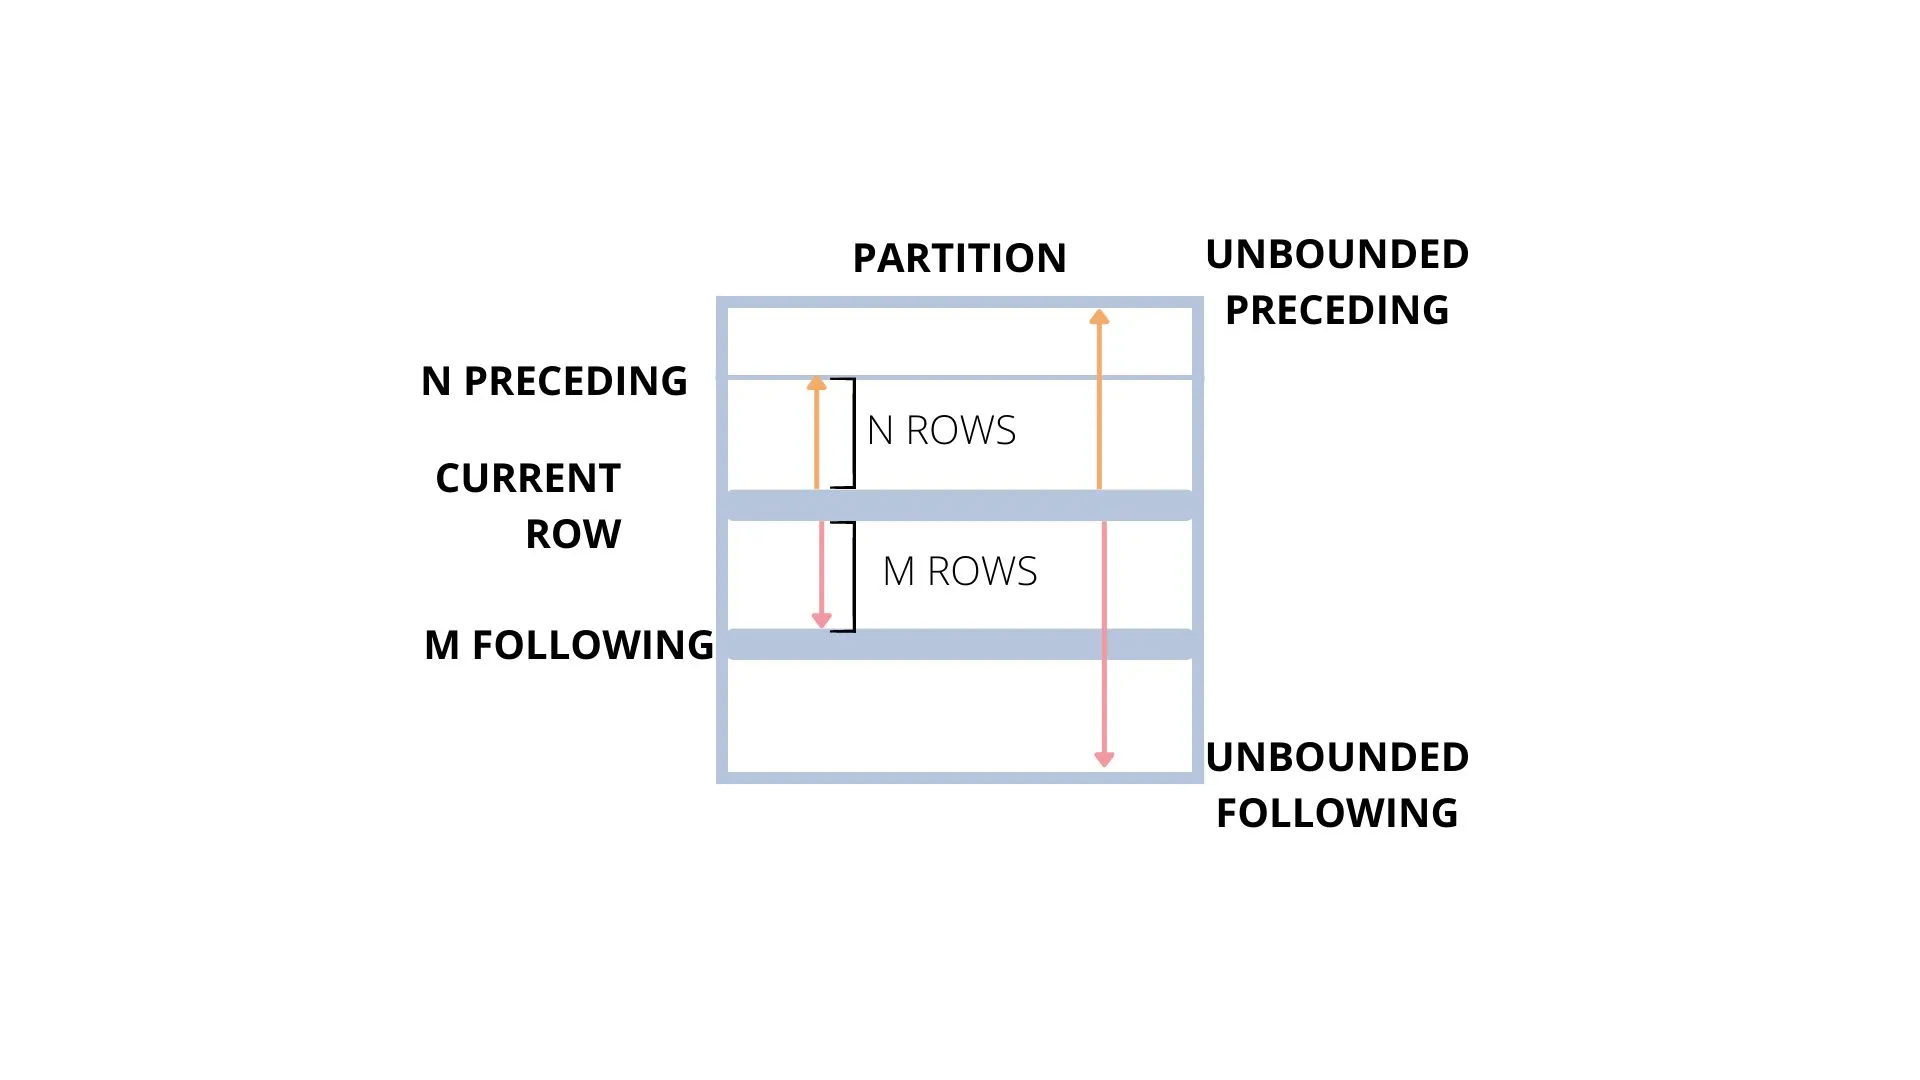

In [43]:
df = pd.DataFrame({
    "id":      [1, 2, 3, 4, 5, 6],
    "amount":  [10, 10, 10, 20, 20, 30],
})
df

,id,amount
0,1,10
1,2,10
2,3,10
3,4,20
4,5,20
5,6,30


In [44]:
duckdb.sql("CREATE OR REPLACE TABLE t AS SELECT * FROM df")

Example of same operation between different boundaries.

In [45]:
duckdb.sql("""
SELECT
    id,
    amount,

    SUM(amount) OVER (
        ORDER BY amount
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS sum_up_to_current,

    SUM(amount) OVER (
        ORDER BY amount
        ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING
    ) AS sum_from_current,

    SUM(amount) OVER (
        ORDER BY amount
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
    ) AS sum_full_partition

FROM t
ORDER BY amount, id
""")

┌───────┬────────┬───────────────────┬──────────────────┬────────────────────┐
│  id   │ amount │ sum_up_to_current │ sum_from_current │ sum_full_partition │
│ int64 │ int64  │      int128       │      int128      │       int128       │
├───────┼────────┼───────────────────┼──────────────────┼────────────────────┤
│     1 │     10 │                10 │              100 │                100 │
│     2 │     10 │                20 │               90 │                100 │
│     3 │     10 │                30 │               80 │                100 │
│     4 │     20 │                50 │               70 │                100 │
│     5 │     20 │                70 │               50 │                100 │
│     6 │     30 │               100 │               30 │                100 │
└───────┴────────┴───────────────────┴──────────────────┴────────────────────┘

**3.) EXCLUDE**

Exclude certain rows, based on current row, or by default don't exclude anything.

NO OTHERS = exclude nothing.

CURRENT ROW = exclude current row.

TIES = exclude all rows tied with the current row.

GROUP =  every peer group inside the frame.

In [46]:
df = pd.DataFrame({
    "id":      [1, 2, 3, 4, 5, 6],
    "amount":  [10, 10, 10, 20, 20, 30],
})
df

,id,amount
0,1,10
1,2,10
2,3,10
3,4,20
4,5,20
5,6,30


In [47]:
duckdb.sql("CREATE OR REPLACE TABLE t AS SELECT * FROM df")


In [48]:
duckdb.sql("""
SELECT
    id,
    amount,

    -- Default: EXCLUDE NO OTHERS
    SUM(amount) OVER (
        ORDER BY amount
        RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        EXCLUDE NO OTHERS
    ) AS no_others,

    -- Remove only the current row
    SUM(amount) OVER (
        ORDER BY amount
        RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        EXCLUDE CURRENT ROW
    ) AS exclude_current,

    -- Remove all rows tied with current row
    SUM(amount) OVER (
        ORDER BY amount
        RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        EXCLUDE TIES
    ) AS exclude_ties,

    -- Remove all peer groups inside the frame
    SUM(amount) OVER (
        ORDER BY amount
        RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        EXCLUDE GROUP
    ) AS exclude_group

FROM t
ORDER BY amount, id
""")

┌───────┬────────┬───────────┬─────────────────┬──────────────┬───────────────┐
│  id   │ amount │ no_others │ exclude_current │ exclude_ties │ exclude_group │
│ int64 │ int64  │  int128   │     int128      │    int128    │    int128     │
├───────┼────────┼───────────┼─────────────────┼──────────────┼───────────────┤
│     1 │     10 │        30 │              20 │           10 │          NULL │
│     2 │     10 │        30 │              20 │           10 │          NULL │
│     3 │     10 │        30 │              20 │           10 │          NULL │
│     4 │     20 │        70 │              50 │           50 │            30 │
│     5 │     20 │        70 │              50 │           50 │            30 │
│     6 │     30 │       100 │              70 │          100 │            70 │
└───────┴────────┴───────────┴─────────────────┴──────────────┴───────────────┘